In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc
import datetime as dt

In [2]:
df = pd.read_csv('./data/BTCDaily.csv')
df.drop_duplicates()
df['date'] = pd.to_datetime(df['date'])
date_range = str(df['date'].dt.date.min()) + ' ' + str(df['date'].dt.date.max())

print(date_range)

2014-11-28 2022-03-01


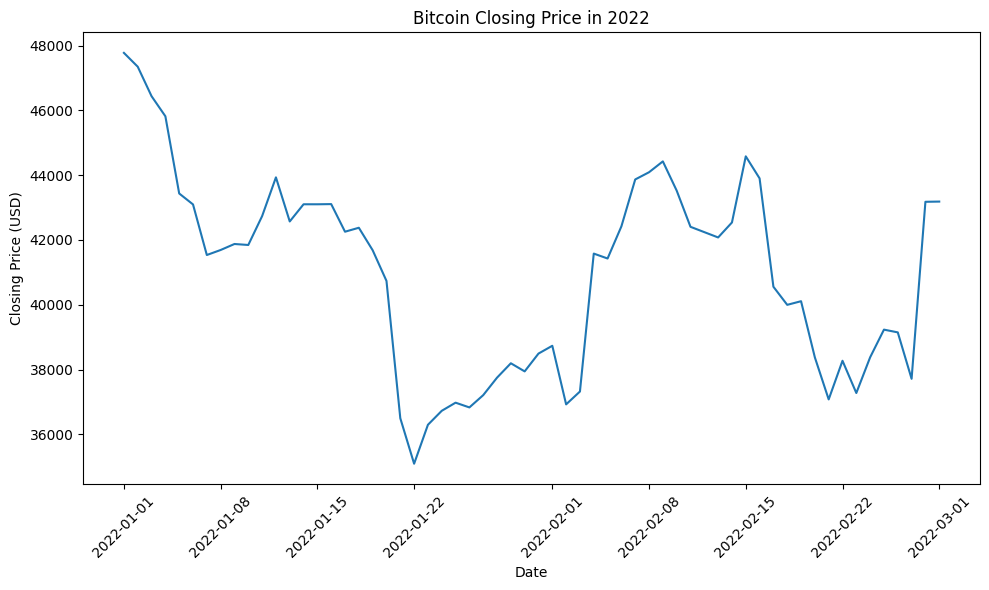

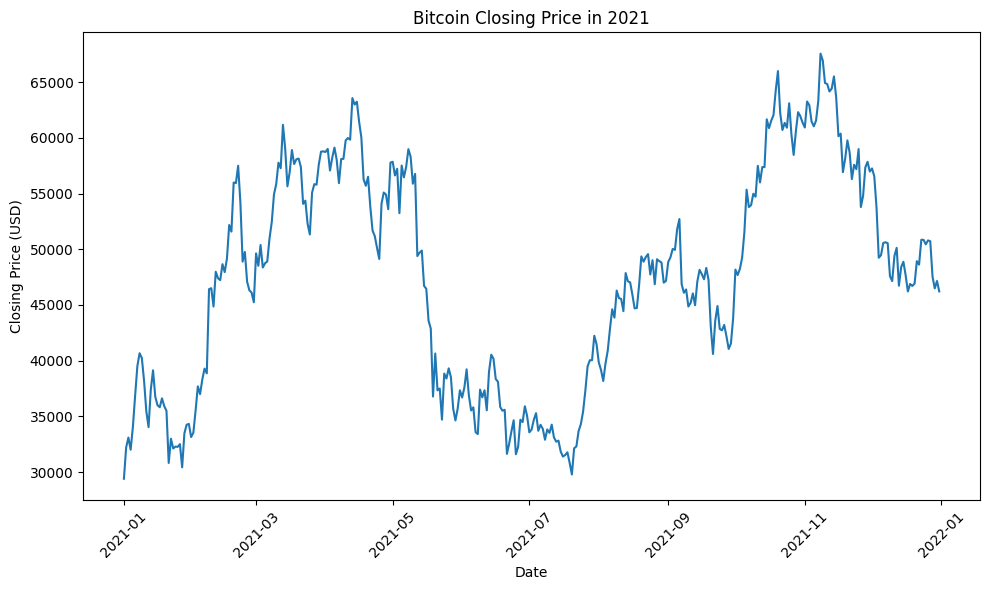

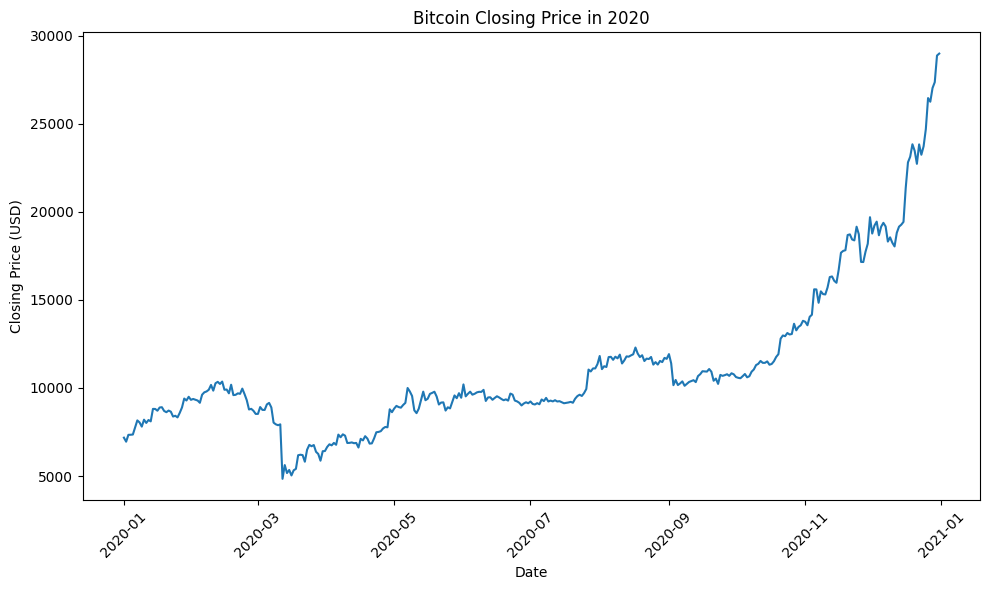

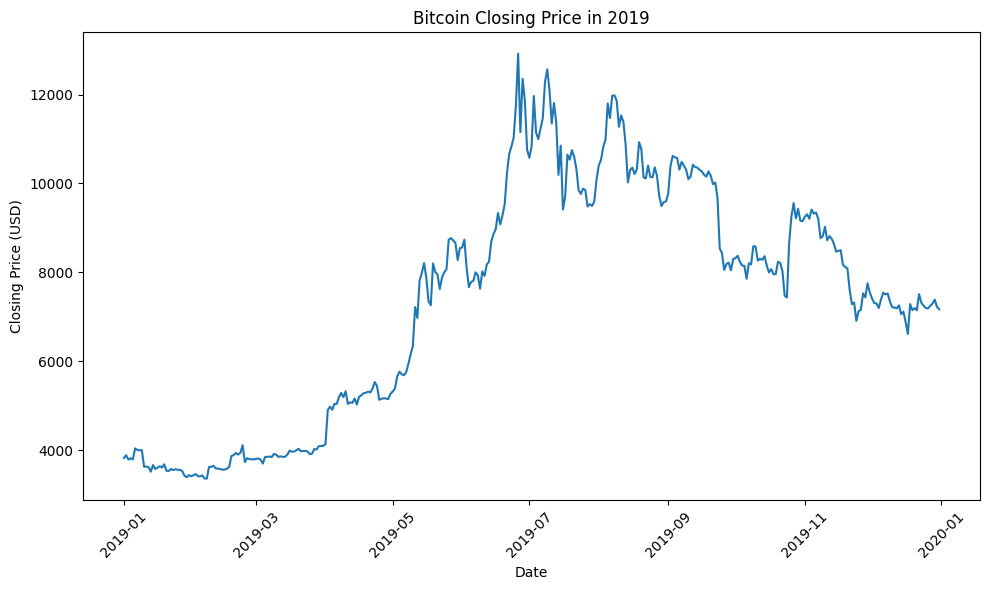

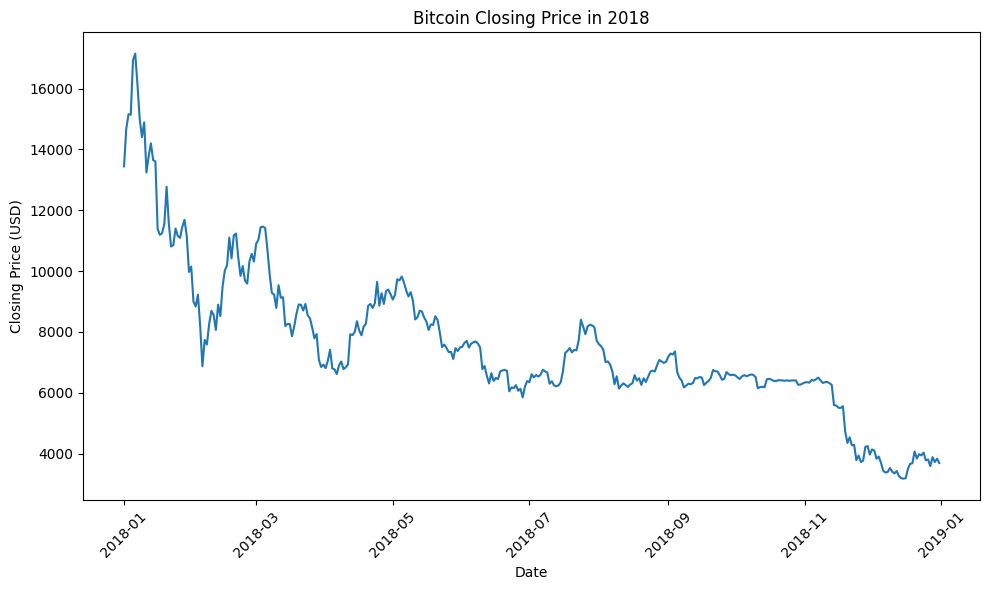

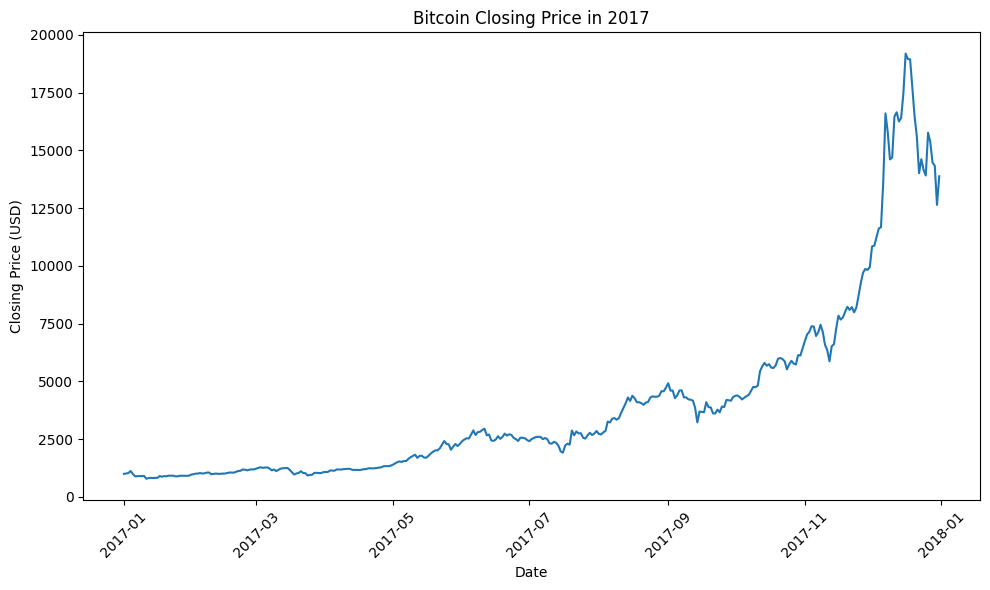

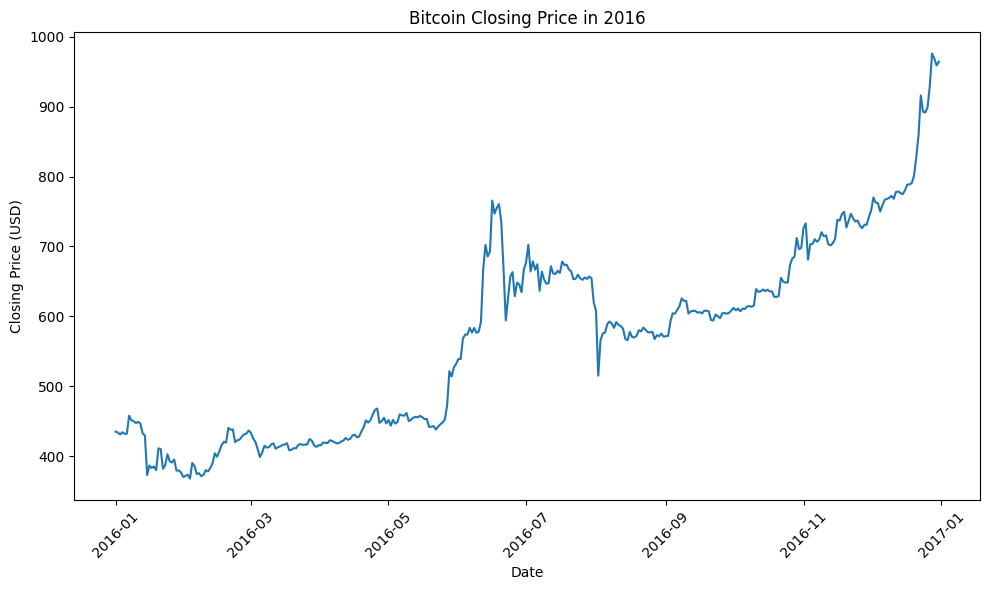

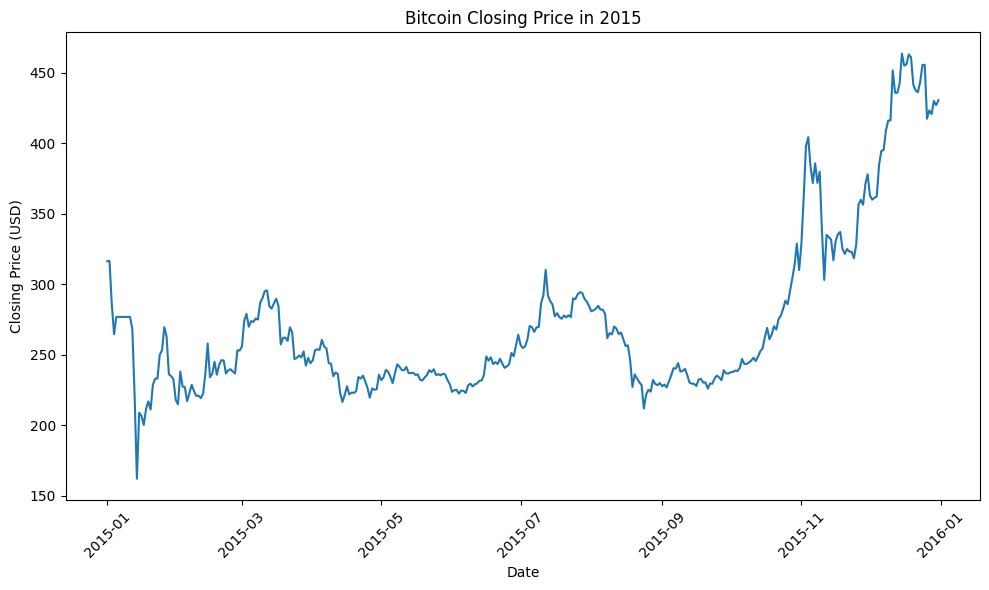

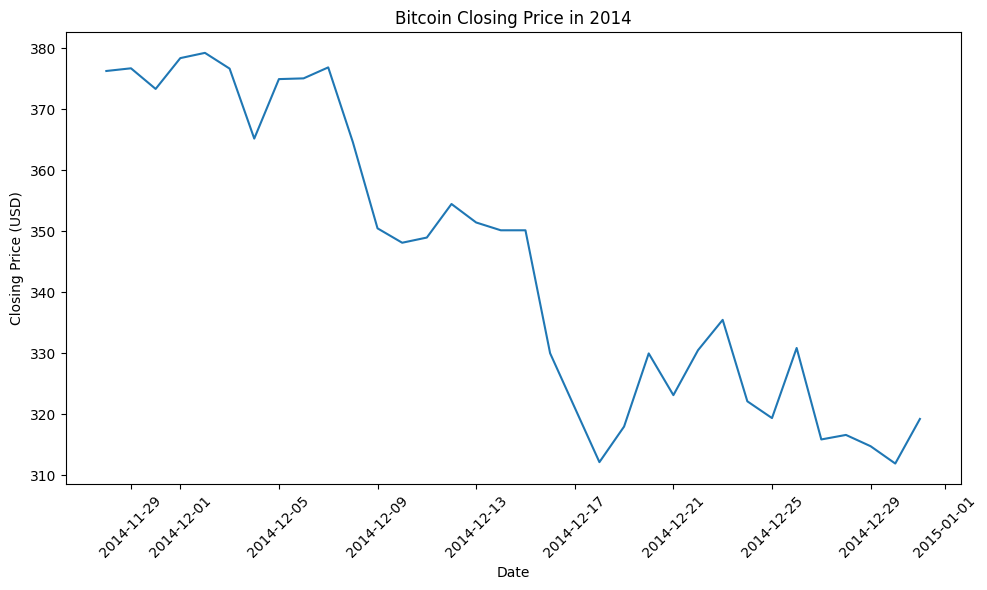

In [5]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

unique_years = df['year'].unique()
for year in unique_years:
    dates = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31', freq='D')
    year_month_day = pd.DataFrame({'date': dates})
    year_month_day['year'] = year_month_day['date'].dt.year
    year_month_day['month'] = year_month_day['date'].dt.month
    year_month_day['day'] = year_month_day['date'].dt.day

    merged_data = pd.merge(year_month_day, df, on=['year', 'month', 'day'], how='left')

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(merged_data['date_x'], merged_data['close'])
    plt.title(f'Bitcoin Closing Price in {year}')
    plt.xlabel('Date')
    plt.ylabel('Closing Price (USD)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



/var/folders/2j/q1vm5k5913l54wl9kxkntwkm0000gn/T/ipykernel_63537/888149313.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['date'] = df_filtered['date'].map(mdates.date2num)


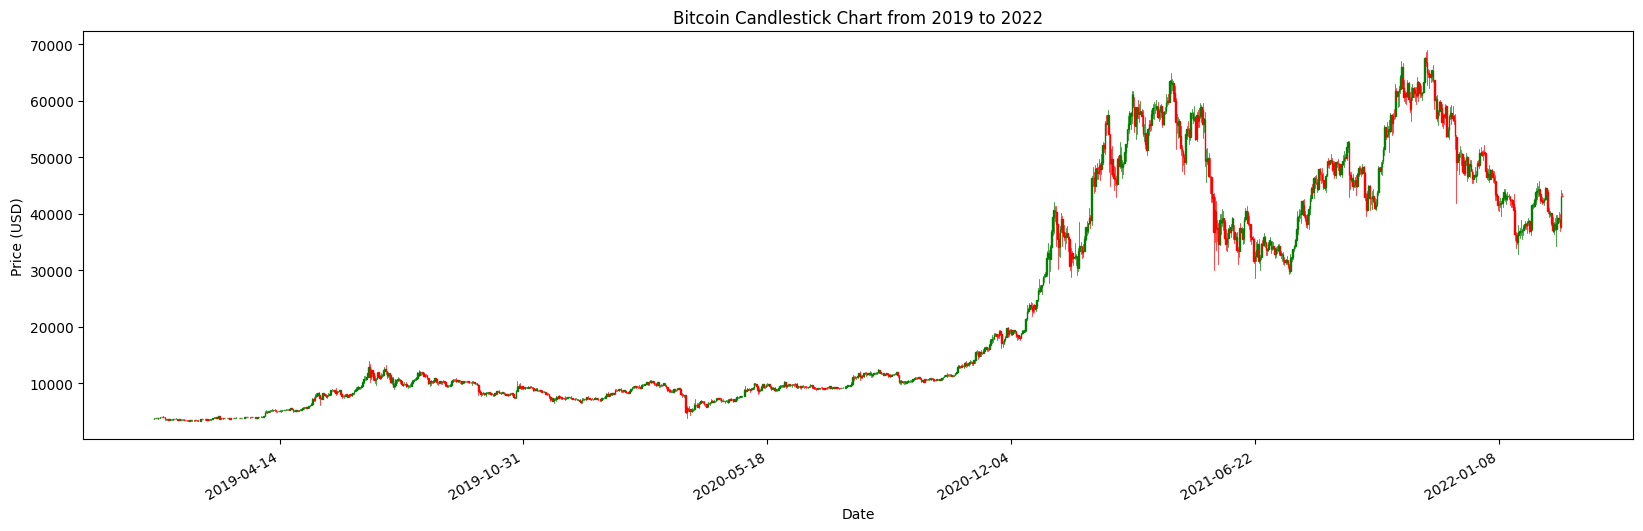

In [9]:
df_filtered = df[(df['date'] >= '2019-01-01') & (df['date'] <= '2022-12-31')]

df_filtered['date'] = df_filtered['date'].map(mdates.date2num)

fig, ax = plt.subplots(figsize=(20, 6))

candlestick_ohlc(ax, df_filtered[['date', 'open', 'high', 'low', 'close']].values, width=0.6, colorup='g', colordown='r')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()

plt.title('Bitcoin Candlestick Chart from 2019 to 2022')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show()



### Standardizing the prices for modeling and plotting them

In [11]:
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
df["Standardized_Close_Prices"] = scalar.fit_transform(df[["close"]]).values.reshape(-1, 1)
df["Standardized_Open_Prices"] = scalar.fit_transform(df[["open"]]).values.reshape(-1, 1)
df["Standardized_High_Prices"] = scalar.fit_transform(df[["high"]]).values.reshape(-1, 1)
df["Standardized_Low_Prices"] = scalar.fit_transform(df[["low"]]).values.reshape(-1, 1)


## Build forecasting model

In [12]:
df['date_str'] = df['date'].dt.strftime("%Y%m%d%H%M%S")

df['NumericalDate'] = pd.to_numeric(df['date_str'])

df.drop(columns=['date_str'], inplace=True)



### Linear Regression Model with its Evaluation

In [13]:
def predict(X, w, b):
    return X.dot(w) + b

def gradient(y_hat, y, x):
    loss = y_hat - y
    dw = x.T.dot(loss) / len(y)
    db = np.sum(loss) / len(y)
    cost = np.sum(loss ** 2) / (2 * len(y))
    return (dw, db, cost)

def update_weights(w, b, lr, dw, db):
    w_new = w - lr * dw
    b_new = b - lr * db
    return (w_new, b_new)

def linear_regression_vectorized(X, y, learning_rate = 0.01, num_iterations = 200):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    b = 0
    losses = []

    for _ in range(num_iterations):
        y_hat = predict(X, w, b)
        dw, db, cost = gradient(y_hat, y, X)
        w, b = update_weights(w, b, learning_rate, dw, db)
        losses.append(cost)

    return w, b, losses




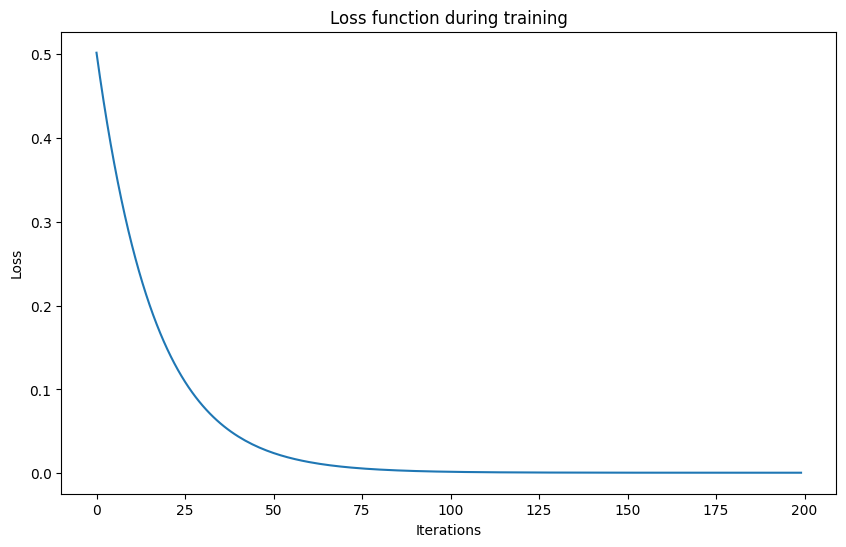

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import cross_val_score

# Split the data into training and testing sets
X = df[['Standardized_Open_Prices', 'Standardized_High_Prices', 'Standardized_Low_Prices']]
y = df['Standardized_Close_Prices']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)

b = 0
w = np.zeros(X_train.shape[1])
lr = 0.01
epochs = 200

w, b, losses = linear_regression_vectorized(X_train.values, y_train.values, lr, epochs)

# plot the loss function
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Loss function during training')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()




In [21]:
from sklearn.metrics import r2_score

# Make predictions on the test set
y_pred = predict(X_test, w, b)

# Calculate RMSE
rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))

# Calculate MAE
mae = np.mean(np.abs(y_pred - y_test))

# Calculate MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100


# Calculate R-squared on training data
y_train_pred = predict(X_train, w, b)
train_accuracy = r2_score(y_train, y_train_pred)

# Calculate R-squared on testing data
test_accuracy = r2_score(y_test, y_pred)

print("Root Mean Square Error (RMSE):", round(rmse, 4))
print("Mean Absolute Error (MAE):", round(mae, 4))
print("Training Accuracy (R-squared):", round(train_accuracy, 4))
print("Testing Accuracy (R-squared):", round(test_accuracy, 4))

Root Mean Square Error (RMSE): 0.0297
Mean Absolute Error (MAE): 0.0138
Training Accuracy (R-squared): 0.9989
Testing Accuracy (R-squared): 0.9991


### Test model from 01/01/2019 - 01/04/2019

In [ ]:
df_2019_q1 = df[(df['date'] >= '2019-01-01') & (df['date'] <= '2019-03-31')]

X_2019_q1 = df_2019_q1[['open', 'high', 'low']]
y_2019_q1_actual = df_2019_q1['close']


y_2019_q1_pred = predict(X_2019_q1, w, b)


# plot the actual and predicted prices
plt.figure(figsize=(12, 6))
plt.plot(df_2019_q1['date'], y_2019_q1_actual, label='Actual Prices', marker='o')
plt.plot(df_2019_q1['date'], y_2019_q1_pred, label='Predicted Prices', marker='o')
plt.title('Actual vs Predicted Prices in Q1 2019')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()